In [1]:
!apt install graphviz
!pip install pydot pydot-ng
!echo "Double check with Python 3"
!python -c "import pydot"

Reading package lists... Done
Building dependency tree       
Reading state information... Done
graphviz is already the newest version (2.40.1-2).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.
Double check with Python 3


In [0]:
import os
os._exit(0)

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [2]:
!nvidia-smi

Sat Nov 16 10:35:45 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 430.50       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [3]:
%pip install nlpaug

     |████████████████████████████████| 92kB 5.6MB/s 


In [0]:
%pip install torch>=1.2.0 transformers>=2.0.0

In [5]:
%tensorflow_version 1.x
import pandas as pd
import time

import numpy as np
from numpy.random import seed
seed(9)

import tensorflow as tf
from tensorflow import set_random_seed
set_random_seed(9)

import json
import nltk
from nltk.tokenize import WordPunctTokenizer
import keras
import re

nltk.download("popular")
print(tf.__version__)

Using TensorFlow backend.


[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/cmudict.zip.
[nltk_data]    | Downloading package gazetteers to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/gazetteers.zip.
[nltk_data]    | Downloading package genesis to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/genesis.zip.
[nltk_data]    | Downloading package gutenberg to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/gutenberg.zip.
[nltk_data]    | Downloading package inaugural to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/inaugural.zip.
[nltk_data]    | Downloading package movie_reviews to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping corpora/movie_reviews.zip.
[nltk_data]    | Downloading package names to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/names.zip.
[nltk_data]    | Downloading package shakespeare to /root/nltk_data...
[nlt

In [0]:
dataover = pd.read_csv("gdrive/My Drive/TFG/tmdb_spanish_def.csv", sep='#',encoding='utf-8', lineterminator='\n')
taste = pd.read_csv("gdrive/My Drive/TFG/tmdb_spanish_Jaime_def.csv", sep='#', encoding='utf-8')

In [0]:
taste = taste[~taste['id'].str.contains('/')]
taste['id'] = taste['id'].astype(int)

In [0]:
# Merge taste and credits

data = taste.merge(dataover[['id','title','overview','genres','crew','cast']], left_on='id', right_on='id')

In [9]:
data = data[~pd.isna(data.overview)]
len(data)

11166

In [10]:
data = data.dropna(subset=['like'])
data['like'] = data['like'].astype(int)
data.reset_index(inplace=True,drop=True)
len(data)

1109

In [0]:
# Clean overviews ver que ocurre con deadpool y deadpool 2 

import string

stop_words = pd.read_csv("gdrive/My Drive/TFG/stopwords-es.txt",header=None)
stop_words = stop_words[0].tolist() + ['secuela']

def normalize(s):
    replacements = (
        ("á", "a"),
        ("é", "e"),
        ("í", "i"),
        ("ó", "o"),
        ("ú", "u"),
        ("ñ", "n")
    )
    for a, b in replacements:
        s = s.replace(a, b).replace(a.upper(), b.upper())
    return s

def clean_overview(x):
    x = normalize(x.lower())
    words = WordPunctTokenizer().tokenize(x)
    x = str(' '.join(words))
    x = re.sub(' +', ' ', x)
    return x

def delete_stop_words(x):
    x = x.translate(str.maketrans('','',string.punctuation))
    x = x.translate(str.maketrans('','','1234567890ªº¡¿'))
    words = x.split(' ')
    words = [word for word in words if word not in stop_words]
    x = str(' '.join(words))
    return x


In [0]:
data['overview']=data['overview'].apply(lambda x: clean_overview(str(x)))
data['title']=data['title'].apply(lambda x: clean_overview(str(x)))

In [0]:
# Steaming overview

from nltk import word_tokenize
from nltk.stem import SnowballStemmer

stemmer = SnowballStemmer("spanish", ignore_stopwords=True)

def stem_sentence(sentence):
    stemmed_text = [stemmer.stem(word) for word in word_tokenize(sentence)]
    return " ".join(stemmed_text)
  

In [14]:
import nlpaug.augmenter.char as nac
import nlpaug.augmenter.word as naw
import nlpaug.augmenter.sentence as nas
import nlpaug.flow as naf

from nlpaug.util import Action

aug = naf.Sequential([
    naw.ContextualWordEmbsAug(model_path='bert-base-multilingual-uncased', action="insert", aug_p=0.1),
    naw.ContextualWordEmbsAug(model_path='bert-base-multilingual-uncased', action="substitute", aug_p=0.4),
    naw.RandomWordAug(action="delete", aug_p=0.1)
])

def augment(x):
  try:
    return aug.augment(x)
  except:
    return None


100%|██████████| 672271273/672271273 [00:26<00:00, 25563063.64B/s]


In [0]:
def eval_cell(cell):
  
  try:
    
    cell_array = eval(cell)
  
  except:
    
    cell_array = []
  
  return cell_array


# Get ids
def get_ids(cell):
  
  cell_array = eval_cell(cell)

  if len(cell_array)>0:
    ids_list = [v['name'] for v in cell_array]
    
  else:
    ids_list = []
  
  return ids_list

def get_cast_ids(cell):
  
  cell_array = eval_cell(cell)
  
  if len(cell_array) >= 3:
    lim = 3
  else:
    lim = len(cell_array)
    
  ids_list = [cell_array[i]['name'] for i in range(0,lim)]
  
  return ids_list

def get_crew_ids(cell,filter_staff):
  
  cell_array = eval_cell(cell)
    
  staff_members_ids = [member['name'] for member in cell_array if member['job'] == filter_staff]
    
  return staff_members_ids


# Ver si cambio ids por nombres
from sklearn.preprocessing import MultiLabelBinarizer

# Crate Dataframe with ids
def create_df_ids(data, ids, column_name, enc=None):
  
  if enc==None:
    enc = MultiLabelBinarizer()
    np_ids = enc.fit_transform(ids)
  else:
    np_ids = enc.transform(ids)
  
  # Save encoder in a pickle
  
  column_names = []
  print('Num classes of '+ column_name + ': ' + str(len(enc.classes_)))
  
  for c in enc.classes_:
    column_names.append(column_name + '_' + str(c))
  
  df_ids = pd.DataFrame(data = np_ids, index=data.index, columns=column_names)
  
  return df_ids,enc


# Merge dataframe ids with data
def create_df_labels(data, column_name, enc=None):
  
  if column_name == 'crew':
    ids = data['crew'].apply(lambda x: get_crew_ids(x,'Director'))
  
  elif column_name == 'cast':
    ids = data[column_name].apply(lambda x: get_cast_ids(x))
    
  else:
    ids = data[column_name].apply(lambda x: get_ids(x))

  df_ids,enc = create_df_ids(data,ids,column_name, enc)
  
  #df = data.copy()
  # df = df.join(df_ids)
  
  return df_ids, enc

In [0]:
from sklearn.model_selection import train_test_split

df = data[['title','overview','cast','crew','genres','like']]

train, test = train_test_split(df, test_size=0.15, stratify=df['like'], random_state=1996)

In [0]:
# Generate training data

from multiprocessing import Pool

def parallelize_dataframe(df, func, n_cores=4):
    df_split = np.array_split(df, n_cores)
    pool = Pool(n_cores)
    df = pd.concat(pool.map(func, df_split))
    pool.close()
    pool.join()
    return df

In [0]:
def transform_over(df):
  df['overview'] = df['overview'].apply(lambda x: stem_sentence(x))
  df['overview'] = df['overview'].apply(lambda x: delete_stop_words(x))
  df['overview'] = df['overview'].apply(lambda x: clean_overview(x))

  df['title'] = df['title'].apply(lambda x: stem_sentence(x))
  df['title'] = df['title'].apply(lambda x: delete_stop_words(x))
  df['title'] = df['title'].apply(lambda x: clean_overview(x))

  return df

train = parallelize_dataframe(train, transform_over)
test = parallelize_dataframe(test, transform_over)

In [71]:
train_title = train.title.values
test_title = test.title.values
train_overview = train.overview.values
test_overview = test.overview.values

train_genres,enc_genres = create_df_labels(train,'genres')
test_genres,enc_genres = create_df_labels(test,'genres',enc_genres)
var_genres = train_genres.var()
to_drop = var_genres[var_genres<0.01].keys()
train_genres = train_genres.drop(columns=to_drop)
test_genres = test_genres.drop(columns=to_drop)

train_cast,enc_cast = create_df_labels(train,'cast')
test_cast,enc_cast = create_df_labels(test,'cast',enc_cast)
var_cast = train_cast.var()
to_drop = var_cast[var_cast<0.005].keys()
train_cast = train_cast.drop(columns=to_drop)
test_cast = test_cast.drop(columns=to_drop)

train_crew,enc_crew = create_df_labels(train,'crew')
test_crew,enc_crew = create_df_labels(test,'crew',enc_crew)
var_crew= train_crew.var()
to_drop = var_crew[var_crew<0.004].keys()
train_crew = train_crew.drop(columns=to_drop)
test_crew = test_crew.drop(columns=to_drop)

train_features = train_genres.join(train_cast).join(train_crew).values
test_features = test_genres.join(test_cast).join(test_crew).values

y_train = train.like.values
y_test = test.like.values

Num classes of genres: 19
Num classes of genres: 19
Num classes of cast: 1587
Num classes of cast: 1587


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:951: UserWarning: unknown class(es) ['A.J. Cook', 'Aaran Thomas', 'Adam Scott', 'Adrián Alonso Barona', 'Aggy K. Adams', 'Alan Cappelli Goetz', 'Alex Pettyfer', 'Alexander Gould', 'Alexis Bledel', 'Alice Lowe', 'Alison Sudol', 'Aly Michalka', 'Andrea Bowen', 'Anil Kapoor', 'Anjelica Huston', 'Antonio de la Torre', 'Ashley Benson', 'Barney Clark', 'Basil Eidenbenz', 'Ben Burtt', 'Bill Goldberg', 'Billy West', 'Bob Hoskins', 'Breanna Yde', 'Brennan Elliott', 'Brian Murray', 'Brooke Butler', 'Carlos Alcantara', 'Charles Dance', 'Charles S. Dutton', 'Chelsea Field', 'Chris Wedge', 'Craig Ferguson', 'Craig Parkinson', 'Crista Flanagan', 'Cyril Roy', 'Daniel Henney', 'Daniel Stern', 'Daniela Bianchi', 'David Cajal', 'David Hyde Pierce', 'David Morrissey', 'David Strathairn', 'Demi Lovato', 'Demián Bichir', 'Dennis Hopper', 'Diego Cortina Autrey', 'Don Johnson', 'Eartha Kitt', 'Edward James Olmos', 'Elisabeth Shue', 'Elissa

Num classes of crew: 674
Num classes of crew: 674


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:951: UserWarning: unknown class(es) ['Adam B. Stein', 'Adam Shankman', 'Andrea Mugnaini', 'Annabel Jankel', 'Baran bo Odar', 'Barry Cook', 'Brad Peyton', 'Bradley Cooper', 'C. Jay Cox', 'Chris Wedge', 'Corin Hardy', 'Cory Edwards', 'Cristina Jacob', 'David Kellogg', 'Dean Parisot', 'Don Hall', 'Dylan Bank', 'Edward Zwick', 'Espen Sandberg', 'Frank Pérez-Garland', 'Gaspar Noé', 'Geoffrey Sax', 'Gurinder Chadha', 'Hans Petter Moland', 'Harmony Korine', 'Ismael Prego Botana', 'Jake Helgren', 'Jane Campion', 'Joe Pytka', 'John G. Avildsen', 'John Madden', 'John Pasquin', 'Jonathan Liebesman', 'Kevin Bray', 'Loveleen Tandan', 'Luca Guadagnino', 'Marco Polo Constandse', 'Mark Dindal', 'Mic Rodgers', 'Mike Thurmeier', 'Morten Tyldum', 'Nacho Vigalondo', 'Patty Jenkins', 'Peter Webber', 'Phil Claydon', 'Rian Johnson', 'Richard Linklater', 'Rocky Morton', 'Rodrigo Sorogoyen', 'Savage Steve Holland', 'Scott Speer', 'Shane Acke

count    942.000000
mean      42.855626
std       17.544247
min        6.000000
25%       30.000000
50%       41.000000
75%       55.000000
max       94.000000
Name: overview, dtype: float64


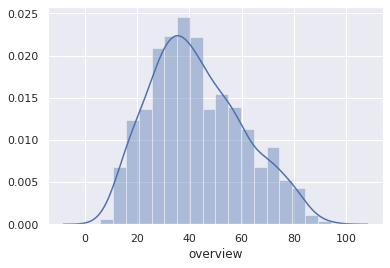

In [72]:
import seaborn as sns
sns.set(color_codes=True)

over_lenghts = train.overview.str.split().apply(len)
print(over_lenghts.describe())

sns.distplot(over_lenghts)

count    942.000000
mean       2.364119
std        1.203125
min        0.000000
25%        2.000000
50%        2.000000
75%        3.000000
max        9.000000
Name: title, dtype: float64


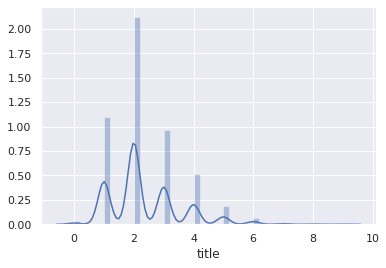

In [73]:
title_lenghts = train.title.str.split().apply(len)
print(title_lenghts.describe())

sns.distplot(title_lenghts)

In [74]:
print(train_title[0])
print(train_overview[0])
print(y_train[0])

dios egipt
supervivent human pend hil beck hero mortal decid salv mund rescat verdader amor consegu busc ayud dios horus establecer alianz set despiad dios oscur usurp tron egipt sum caos gan batall set secuac tendr somet terribl prueb valenti sacrifici
0


In [0]:
# Embedding
num_words_over = 7000
maxlen_over = 80

num_words_title = 1000
maxlen_title = 4

In [76]:
from keras.preprocessing.text import Tokenizer

# Overview
tokenizer_over = Tokenizer(num_words_over) 
tokenizer_over.fit_on_texts(train_overview)
print(train_overview[2]) 

train_overview = tokenizer_over.texts_to_sequences(train_overview) 
test_overview = tokenizer_over.texts_to_sequences(test_overview)

vocab_size_over = len(tokenizer_over.word_index) + 1 # Adding 1 because of reserved 0 index

print(train_overview[2]) 
print(vocab_size_over)

# Max length vector
len(max(train_overview, key=len))

mientr gobiern ee uu clar respond visit alienigen tierr intencion malign amand mur wall lid agenci secret ofrec curios solucion reclut villan cruel habil letal inclus magic trabaj demasi opcion negat supervillan peligr mund acced colabor ejecut peligr mision secret suic logr limpi expedient
[17, 387, 900, 901, 802, 1146, 191, 175, 23, 409, 354, 803, 1513, 1147, 333, 443, 38, 334, 1514, 408, 312, 130, 718, 222, 549, 313, 223, 31, 314, 1148, 1515, 1516, 27, 3, 1295, 510, 1005, 27, 44, 38, 1808, 192, 902, 1006]
7579


94

In [77]:
# Title
tokenizer_title = Tokenizer(num_words_title) 
tokenizer_title.fit_on_texts(train_title)
print(train_title[2]) 

train_title = tokenizer_title.texts_to_sequences(train_title) 
test_title = tokenizer_title.texts_to_sequences(test_title)

vocab_size_title = len(tokenizer_title.word_index) + 1 # Adding 1 because of reserved 0 index

print(train_title[2]) 
print(vocab_size_title)

# Max length vector
len(max(train_title, key=len))

escuadron suic
[149, 150]
1181


7

In [0]:
from keras.preprocessing.sequence import pad_sequences

train_overview = pad_sequences(train_overview, padding='pre', maxlen=maxlen_over)
test_overview = pad_sequences(test_overview, padding='pre', maxlen=maxlen_over)

train_title = pad_sequences(train_title, padding='pre', maxlen=maxlen_title)
test_title = pad_sequences(test_title, padding='pre', maxlen=maxlen_title)


In [0]:
#from tensorflow.keras import backend as K
from keras.callbacks import EarlyStopping

#Optimizer

from keras import optimizers

adam = optimizers.Adam()

In [80]:
from sklearn.utils import class_weight


class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train),
                                                 y_train)

class_weights

array([0.97920998, 1.02169197])

In [0]:
from keras.models import Sequential,Model
from keras.layers import Dense, Dropout, Activation, Convolution1D, MaxPooling1D, Input
from keras.layers import Embedding,CuDNNLSTM, SpatialDropout1D, Reshape, Flatten, BatchNormalization
from keras.layers import Conv1D, GlobalMaxPooling1D, GlobalAveragePooling1D, concatenate, CuDNNGRU
from keras.optimizers import Adam, Adagrad


class MyLayers:

    @staticmethod
    def my_conv1d(kernel_size, layer, filters=10, strides=1, act='relu', reg=None):
        
        c1d = keras.layers.Conv1D(filters=filters, kernel_size=kernel_size, padding='valid', strides=strides,
                                     kernel_initializer='he_uniform', kernel_regularizer=reg)(layer)
        
        if act in ['relu','elu','gelu','sigmoid']:
          if act == 'gelu':
            act = MyLayers.gelu
          c1d = keras.layers.BatchNormalization()(c1d)
          c1d = keras.layers.Activation(act)(c1d)
        
        else:
          c1d = keras.layers.Activation(act)(c1d)
          c1d = keras.layers.BatchNormalization()(c1d)
          
        return c1d

    @staticmethod
    def my_dense(neurons, ant, act='sigmoid', ini='glorot_uniform', reg=None):
      
        dense = keras.layers.Dense(neurons, kernel_initializer=ini, kernel_regularizer=reg)(ant)

        if act in ['relu','elu','gelu','sigmoid']:
          if act == 'gelu':
            act = MyLayers.gelu
          dense = keras.layers.BatchNormalization()(dense)
          dense = keras.layers.Activation(act)(dense)
        
        else:
          dense = keras.layers.Activation(act)(dense)

        return dense

    @staticmethod
    def gelu(x):
        return 0.5 * x * (1 + tf.keras.backend.tanh(np.sqrt(2 / np.pi) * (x + 0.044715 * tf.keras.backend.pow(x, 3))))

    @staticmethod
    def custom_sigmoid(x):
        return keras.backend.sigmoid(x) + tf.keras.backend.epsilon()


In [0]:
embedding_size_over = 300
embedding_size_title = 50
dropout=0.3
kernel=3
filters=64
maxp=2
gnup=32
act='relu'

In [0]:
#########
## X
#########
inp_x = Input(shape=(maxlen_title,))
x =  Embedding(input_dim = vocab_size_title, output_dim = embedding_size_title)(inp_x)
x = SpatialDropout1D(dropout)(x) 

x = CuDNNGRU(gnup, kernel_initializer='glorot_uniform', return_sequences=True)(x)
x = BatchNormalization()(x)
x = GlobalMaxPooling1D()(x)
x = Dropout(dropout)(x)
x = MyLayers.my_dense(neurons=25, ant=x, act=act)

#########
## Y
#########
inp_y = Input(shape=(maxlen_over,))
y =  Embedding(input_dim = vocab_size_over, output_dim = embedding_size_over)(inp_y)
y = SpatialDropout1D(dropout)(y) 

y = MyLayers.my_conv1d(kernel ,y, filters=filters, act=act)
y = MaxPooling1D(pool_size=maxp)(y)
y = Dropout(dropout)(y) 

y = CuDNNGRU(gnup, kernel_initializer='glorot_uniform', return_sequences=True)(y)
y = BatchNormalization()(y)
y = GlobalMaxPooling1D()(y)
y = Dropout(dropout)(y)
y = MyLayers.my_dense(neurons=25, ant=y, act=act)

#########
## Z
#########
inp_z = Input(shape=(len(train_features[0]),))
z = Dropout(dropout)(inp_z)
z = MyLayers.my_dense(neurons=100, ant=z, act=act)
z = Dropout(dropout)(z)
z = MyLayers.my_dense(neurons=50, ant=z, act=act)
z = Dropout(dropout)(z)
z = MyLayers.my_dense(neurons=25, ant=z, act=act)

out = concatenate([x,y,z],axis=-1)
out = Dropout(dropout)(out)
out = MyLayers.my_dense(neurons=50, ant=out, act=act)
out = Dropout(dropout)(out)
out = MyLayers.my_dense(neurons=25, ant=out, act=act)
out = Dense(1, activation='sigmoid')(out)

model = Model(inputs=[inp_x, inp_y, inp_z], outputs=out)

In [110]:
model.compile(optimizer = 'adam', loss = 'binary_crossentropy',  metrics = ['accuracy'])
model.summary()

Model: "model_15"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_44 (InputLayer)           (None, 80)           0                                            
__________________________________________________________________________________________________
embedding_30 (Embedding)        (None, 80, 300)      2273700     input_44[0][0]                   
__________________________________________________________________________________________________
spatial_dropout1d_30 (SpatialDr (None, 80, 300)      0           embedding_30[0][0]               
__________________________________________________________________________________________________
input_45 (InputLayer)           (None, 174)          0                                            
___________________________________________________________________________________________

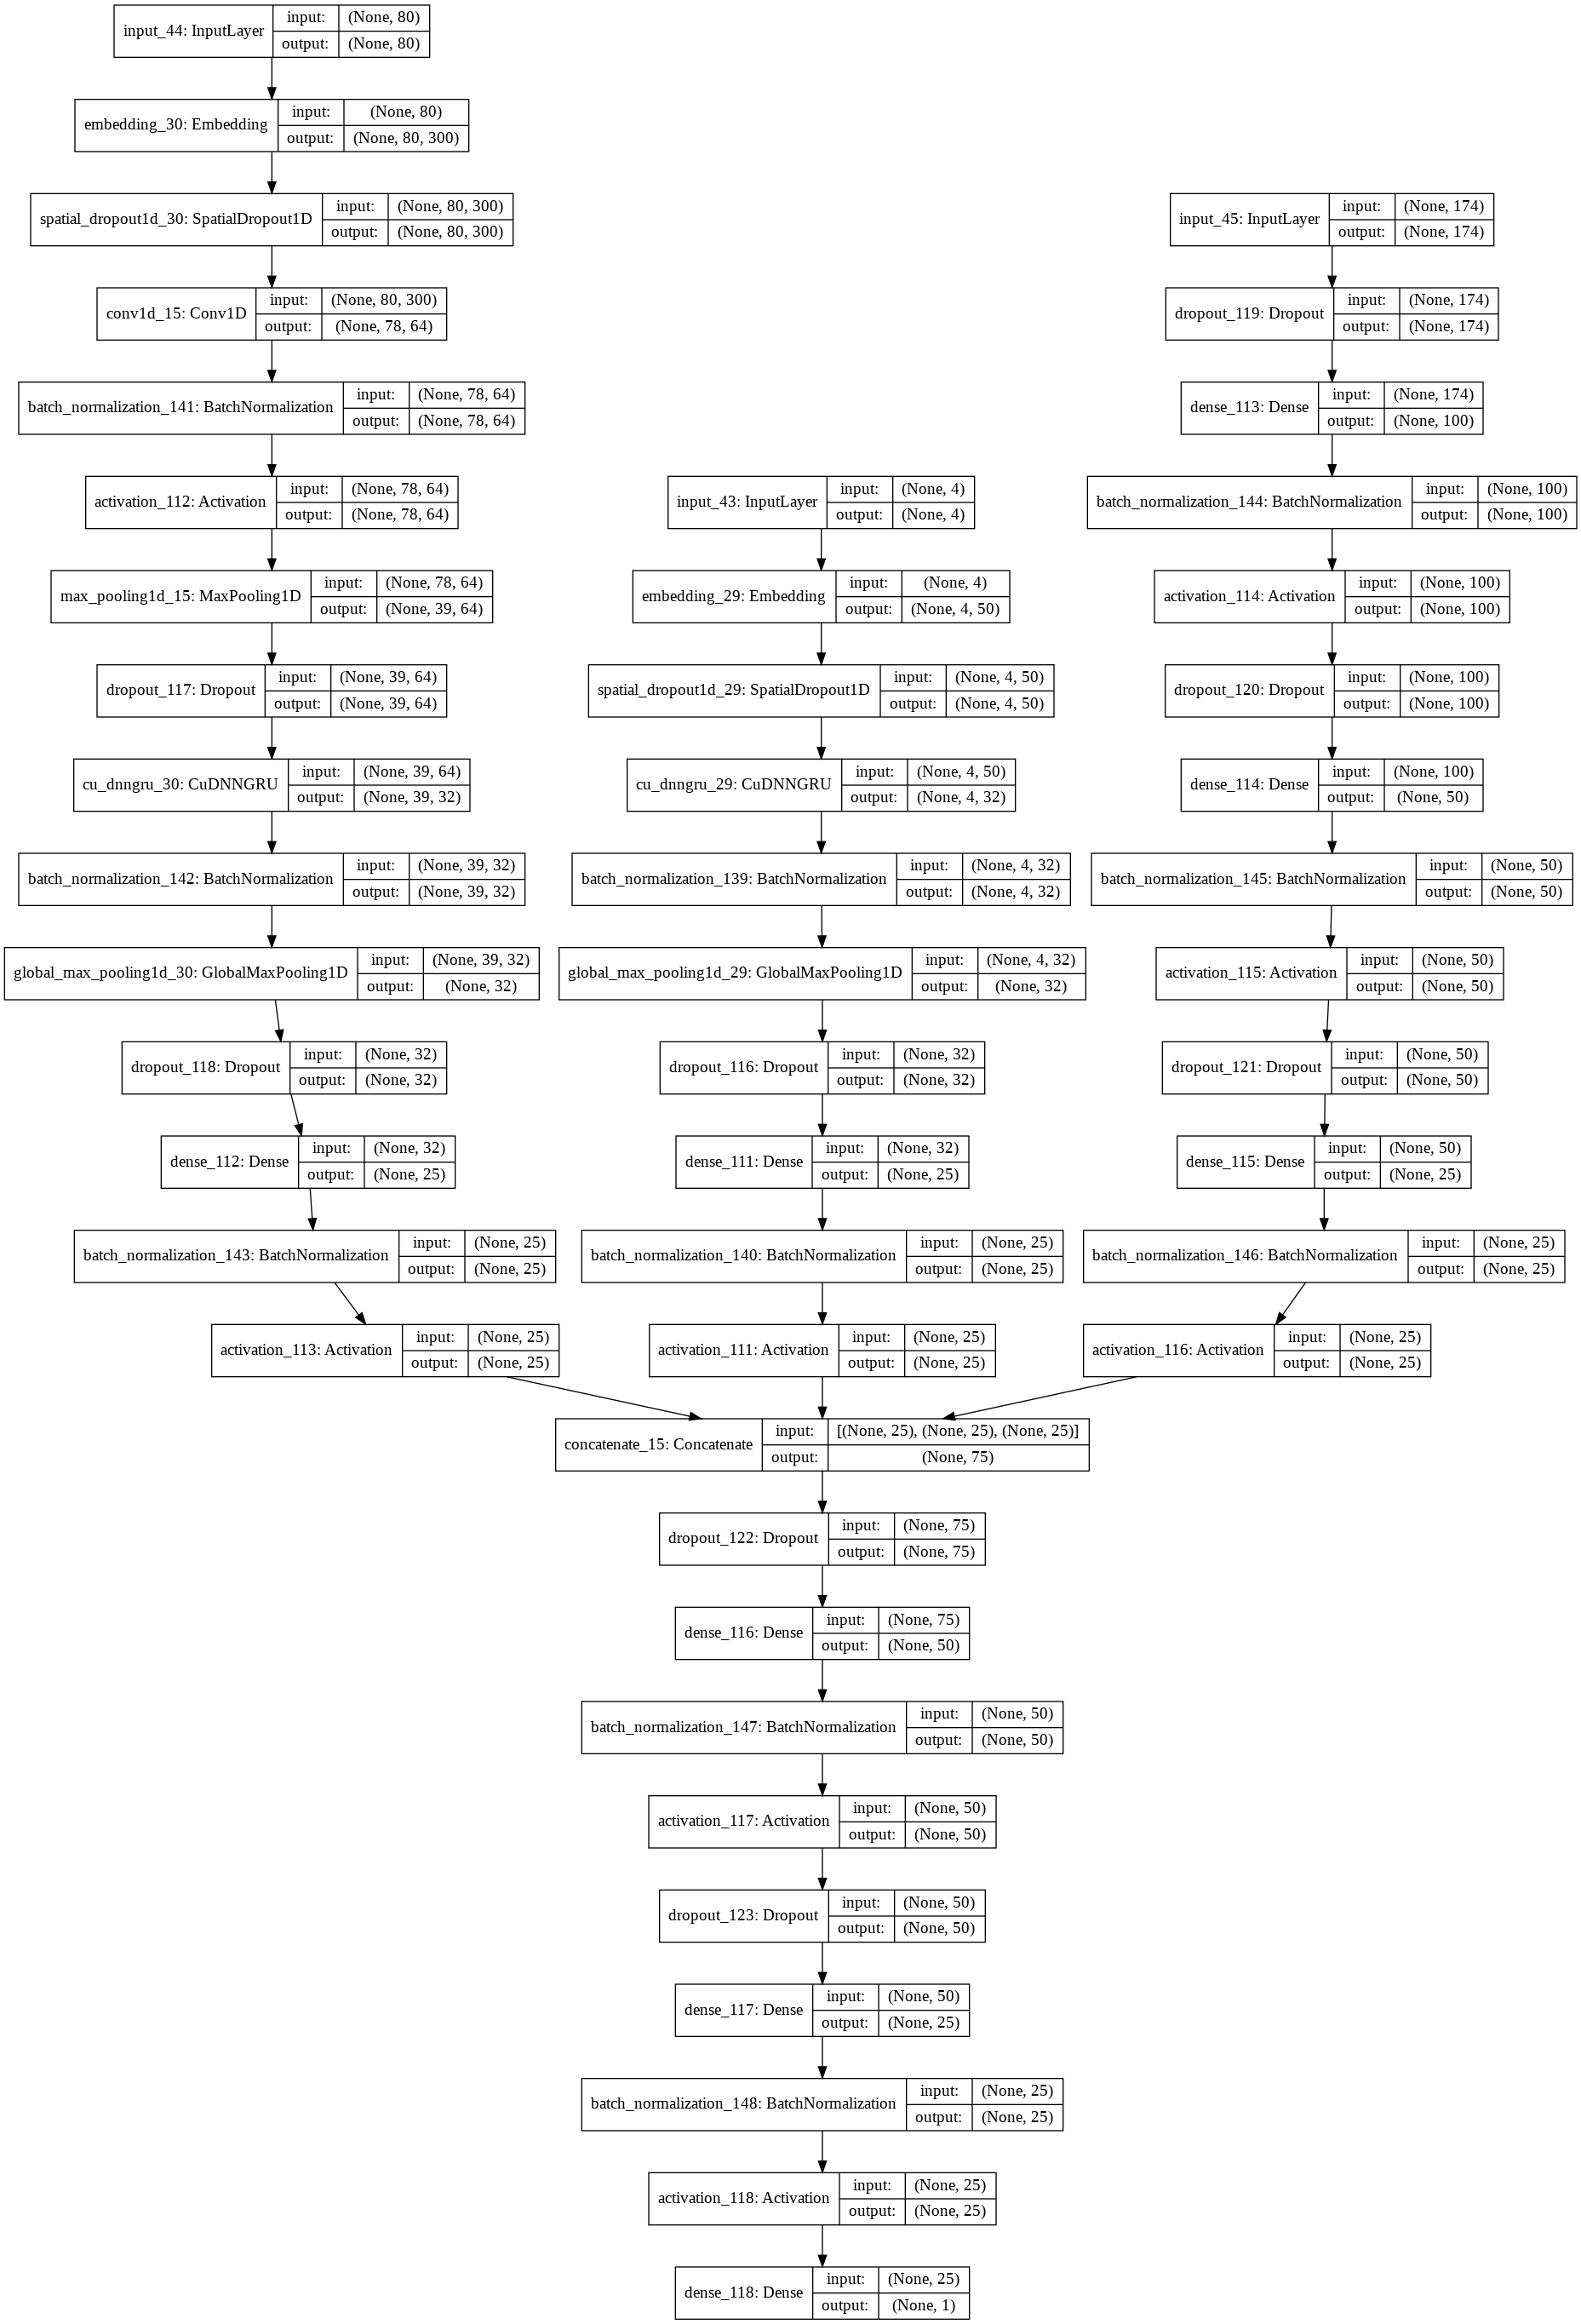

In [111]:
from keras.utils import plot_model

plot_model(model, show_shapes=True, show_layer_names=True, to_file='model.png')
from IPython.display import Image
Image(retina=True, filename='model.png')

In [112]:
 # 75% acc
 hist = model.fit(x=[train_title, train_overview, train_features], y=y_train, 
                  batch_size=64, 
                  validation_data=([test_title, test_overview, test_features], y_test),
                  epochs=20)

Train on 942 samples, validate on 167 samples
Epoch 1/20
942/942 [==============================] - 19s 20ms/step - loss: 0.7837 - acc: 0.4894 - val_loss: 0.6947 - val_acc: 0.5210
Epoch 2/20
942/942 [==============================] - 1s 533us/step - loss: 0.7420 - acc: 0.5244 - val_loss: 0.6836 - val_acc: 0.5449
Epoch 3/20
942/942 [==============================] - 1s 547us/step - loss: 0.7226 - acc: 0.5478 - val_loss: 0.6670 - val_acc: 0.5749
Epoch 4/20
942/942 [==============================] - 1s 543us/step - loss: 0.7132 - acc: 0.5605 - val_loss: 0.6749 - val_acc: 0.5569
Epoch 5/20
942/942 [==============================] - 0s 524us/step - loss: 0.7128 - acc: 0.5393 - val_loss: 0.6762 - val_acc: 0.5449
Epoch 6/20
942/942 [==============================] - 1s 532us/step - loss: 0.6734 - acc: 0.5966 - val_loss: 0.6698 - val_acc: 0.5210
Epoch 7/20
942/942 [==============================] - 0s 526us/step - loss: 0.6791 - acc: 0.5839 - val_loss: 0.6651 - val_acc: 0.5150
Epoch 8/20
942/9

In [0]:
import os

files = os.listdir("gdrive/My Drive/TFG/models/")
files.sort(reverse=True)
print(files)

['weights-08-0.72.hdf5', 'weights-07-0.69.hdf5', 'weights-06-0.67.hdf5', 'weights-04-0.65.hdf5', 'weights-03-0.56.hdf5', 'weights-02-0.51.hdf5', 'weights-01-0.48.hdf5']


In [0]:
model = custom_model_gpu(embedding_size=150,dropout=0.5,filters=64,kernel=3,maxp=2,gnup=32,neurons=8,act='gelu')
#model.load_weights("gdrive/My Drive/TFG/models/" + files[0])
model.compile(optimizer = keras.optimizers.Adam(1), loss = tf.keras.losses.cosine_similarity,  metrics = ['accuracy'])

model.summary()

Model: "model_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_21 (InputLayer)        (None, 60)                0         
_________________________________________________________________
embedding_21 (Embedding)     (None, 60, 150)           1403100   
_________________________________________________________________
spatial_dropout1d_20 (Spatia (None, 60, 150)           0         
_________________________________________________________________
conv1d_21 (Conv1D)           (None, 58, 64)            28864     
_________________________________________________________________
batch_normalization_57 (Batc (None, 58, 64)            256       
_________________________________________________________________
activation_58 (Activation)   (None, 58, 64)            0         
_________________________________________________________________
max_pooling1d_11 (MaxPooling (None, 29, 64)            0  

In [0]:
from keras.callbacks import ModelCheckpoint

filepath="gdrive/My Drive/TFG/models/weights-{epoch:02d}-{val_acc:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', save_best_only=True, verbose=1)

In [0]:
def get_one_hot(x):
  if x==1:
    return [0,1]
  else:
    return [1,0]

In [0]:
y_train2 = np.array([get_one_hot(x) for x in y_train])
y_test2 = np.array([get_one_hot(x) for x in y_test])

In [0]:
y_train2

array([[0, 1],
       [0, 1],
       [0, 1],
       ...,
       [0, 1],
       [1, 0],
       [1, 0]])

In [0]:
history = model.fit(X_train, y_train2,
                    epochs=20,
                    verbose=True,
                    validation_data=(X_test, y_test2),
                    batch_size=4,
                    class_weight=class_weights
                    )

Train on 1964 samples, validate on 123 samples
Epoch 1/20
1964/1964 [==============================] - 14s 7ms/step - loss: -0.4822 - acc: 0.4822 - val_loss: -0.4797 - val_acc: 0.4797
Epoch 2/20
1964/1964 [==============================] - 10s 5ms/step - loss: -0.4822 - acc: 0.4822 - val_loss: -0.4797 - val_acc: 0.4797
Epoch 3/20
 748/1964 [==========>...................] - ETA: 5s - loss: -0.4987 - acc: 0.4987

KeyboardInterrupt: ignored

In [0]:
model2 = custom_model_cpu(embedding_size=150,dropout=0.5,filters=64,kernel=3,maxp=2,gnup=32,neurons=8,act='gelu')
model2.load_weights("gdrive/My Drive/TFG/models/" + files[0])
model2.compile(optimizer = 'adam', loss = 'binary_crossentropy',  metrics = ['accuracy'])

model2.summary()

In [0]:
model2.save('gdrive/My Drive/TFG/models/my_model_movie_like.h5') 

In [0]:
# Parameter space
param_grid = dict(dropout = [0.5],
                  filters1 = [256,512],
                  filters2 = [256,512],
                  kernel = [2,3],
                  maxp = [3,5],
                  gnup = [64,128,256],
                  act = ["relu", MyLayers.gelu],
                  epochs=[20])

In [0]:
from keras.wrappers.scikit_learn import KerasClassifier
model = KerasClassifier(build_fn = custom_model, verbose=1, batch_size = 8)

In [0]:
from sklearn.model_selection import RandomizedSearchCV

grid = RandomizedSearchCV(estimator = model, param_distributions = param_grid, verbose=2, cv = 2)

In [0]:
grid_result = grid.fit(X_train, y_train)

In [0]:
grid.best_score_

0.5281385447383787

In [0]:
 # summarize results
means = pd.DataFrame(grid_result.cv_results_['mean_test_score'], columns = ['Mean'] )
stds = pd.DataFrame(grid_result.cv_results_['std_test_score'], columns = ['SD'])
params = pd.DataFrame(grid_result.cv_results_['params'])

result = pd.concat([means, stds, params],axis = 1).sort_values(by=['Mean'], ascending=False)
print(result.to_string(index=False))

     Mean        SD                                         act  dropout  epochs  filters1  filters2  gnup  kernel  maxp
 0.528139  0.009420  <function MyLayers.gelu at 0x7fd6cc6fc1e0>      0.5      20       512       512    64       3     5
 0.518038  0.022393  <function MyLayers.gelu at 0x7fd6cc6fc1e0>      0.5      20       512       256    64       3     5
 0.516595  0.020947  <function MyLayers.gelu at 0x7fd6cc6fc1e0>      0.5      20       512       512   128       2     3
 0.516595  0.020947  <function MyLayers.gelu at 0x7fd6cc6fc1e0>      0.5      20       512       512   256       3     3
 0.516595  0.020947  <function MyLayers.gelu at 0x7fd6cc6fc1e0>      0.5      20       512       512   256       2     3
 0.516595  0.020947                                        relu      0.5      20       512       256   256       2     3
 0.516595  0.020947                                        relu      0.5      20       256       512   128       3     5
 0.516595  0.020947             

In [0]:
# Model 6 Attention with LSTM
from keras.engine.topology import Layer

def dot_product(x, kernel):
    """
    Wrapper for dot product operation, in order to be compatible with both
    Theano and Tensorflow
    Args:
        x (): input
        kernel (): weights
    Returns:
    """
    if K.backend() == 'tensorflow':
        return K.squeeze(K.dot(x, K.expand_dims(kernel)), axis=-1)
    else:
        return K.dot(x, kernel)
    

class AttentionWithContext(Layer):
    """
    Attention operation, with a context/query vector, for temporal data.
    Supports Masking.
    Follows the work of Yang et al. [https://www.cs.cmu.edu/~diyiy/docs/naacl16.pdf]
    "Hierarchical Attention Networks for Document Classification"
    by using a context vector to assist the attention
    # Input shape
        3D tensor with shape: `(samples, steps, features)`.
    # Output shape
        2D tensor with shape: `(samples, features)`.
    How to use:
    Just put it on top of an RNN Layer (GRU/LSTM/SimpleRNN) with return_sequences=True.
    The dimensions are inferred based on the output shape of the RNN.
    Note: The layer has been tested with Keras 2.0.6
    Example:
        model.add(LSTM(64, return_sequences=True))
        model.add(AttentionWithContext())
        # next add a Dense layer (for classification/regression) or whatever...
    """

    def __init__(self,
                 W_regularizer=None, u_regularizer=None, b_regularizer=None,
                 W_constraint=None, u_constraint=None, b_constraint=None,
                 bias=True, **kwargs):

        self.supports_masking = True
        self.init = initializers.get('glorot_uniform')

        self.W_regularizer = regularizers.get(W_regularizer)
        self.u_regularizer = regularizers.get(u_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.u_constraint = constraints.get(u_constraint)
        self.b_constraint = constraints.get(b_constraint)

        self.bias = bias
        super(AttentionWithContext, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight((input_shape[-1], input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        if self.bias:
            self.b = self.add_weight((input_shape[-1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)

        self.u = self.add_weight((input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_u'.format(self.name),
                                 regularizer=self.u_regularizer,
                                 constraint=self.u_constraint)

        super(AttentionWithContext, self).build(input_shape)

    def compute_mask(self, input, input_mask=None):
        # do not pass the mask to the next layers
        return None

    def call(self, x, mask=None):
        uit = dot_product(x, self.W)

        if self.bias:
            uit += self.b

        uit = K.tanh(uit)
        ait = dot_product(uit, self.u)

        a = K.exp(ait)

        # apply mask after the exp. will be re-normalized next
        if mask is not None:
            # Cast the mask to floatX to avoid float64 upcasting in theano
            a *= K.cast(mask, K.floatx())

        # in some cases especially in the early stages of training the sum may be almost zero
        # and this results in NaN's. A workaround is to add a very small positive number ε to the sum.
        # a /= K.cast(K.sum(a, axis=1, keepdims=True), K.floatx())
        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())

        a = K.expand_dims(a)
        weighted_input = x * a
        return K.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        return input_shape[0], input_shape[-1]

In [0]:
from keras.layers import Bidirectional, CuDNNGRU, SpatialDropout1D
from keras.layers import Bidirectional
from keras.layers import GRU, CuDNNGRU

from keras import optimizers
from keras import backend as K
from keras.engine.topology import Layer
from keras import initializers, regularizers, constraints
from keras.models import Sequential,Model
from keras.layers import Dense, Dropout, Activation, Convolution1D, MaxPooling1D, Input, AveragePooling1D
from keras.layers import Embedding, SpatialDropout1D, Reshape, Flatten, BatchNormalization
from keras.layers import Conv1D, GlobalMaxPooling1D, GlobalAveragePooling1D, Concatenate
from keras.optimizers import Adam, Adagrad

def model_lstm_atten(n_embedding,gru,act1,act2,neurons):
    inp = Input(shape=(maxlen,))
    x = Embedding(input_dim = vocab_size, output_dim = n_embedding)(inp)
    x = SpatialDropout1D(0.5)(x)
    x = CuDNNGRU(gru, kernel_initializer='glorot_uniform', return_sequences=True)(x)
    x = BatchNormalization()(x)
    x = AttentionWithContext()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = MyLayers.my_dense(neurons,x,act='relu', ini='he_uniform', reg=keras.regularizers.l1_l2(l1=0.01, l2=0.01))
    x = MyLayers.my_dense(1,x,act='sigmoid', reg=keras.regularizers.l1_l2(l1=0.01, l2=0.01))
    model = Model(inputs=inp, outputs=x)
    model.compile(loss='binary_crossentropy', optimizer=optimizers.Adam(lr=0.001), metrics=['accuracy'])
    return model
  

In [0]:
model = model_lstm_atten(n_embedding=150,gru=16,act1='gelu',act2='gelu',neurons=32)
model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 100)               0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 100, 150)          1403100   
_________________________________________________________________
spatial_dropout1d_3 (Spatial (None, 100, 150)          0         
_________________________________________________________________
cu_dnngru_3 (CuDNNGRU)       (None, 100, 16)           8064      
_________________________________________________________________
batch_normalization_9 (Batch (None, 100, 16)           64        
_________________________________________________________________
attention_with_context_3 (At (None, 16)                288       
_________________________________________________________________
batch_normalization_10 (Batc (None, 16)                64  

In [0]:
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=150))
model.add(Conv1D(64, 3, activation='relu'))
model.add(Dropout(0.5))
model.add(GlobalMaxPooling1D())
model.add(Dropout(0.5))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))            
optimizer = optimizers.Adam(lr=0.001)
model.compile(optimizer=optimizer,loss='binary_crossentropy',metrics=['accuracy'])

In [0]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, None, 150)         1403100   
_________________________________________________________________
conv1d_5 (Conv1D)            (None, None, 64)          28864     
_________________________________________________________________
dropout_12 (Dropout)         (None, None, 64)          0         
_________________________________________________________________
global_max_pooling1d_5 (Glob (None, 64)                0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_15 (Dense)             (None, 8)                 520       
_________________________________________________________________
dense_16 (Dense)             (None, 1)                

In [0]:
history = model.fit(X_train, y_train,
                    epochs=20,
                    verbose=True,
                    validation_data=(X_test, y_test),
                    batch_size=4,
                    class_weight=class_weights)

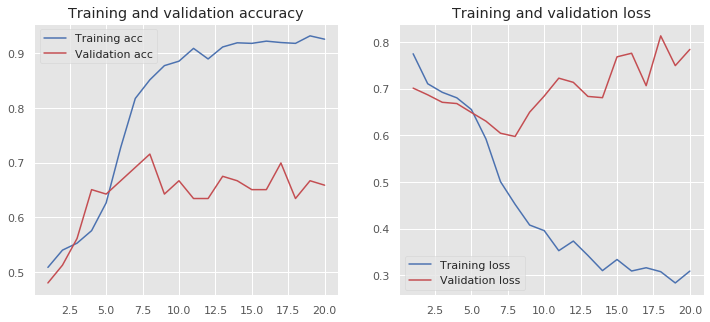

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    
plot_history(history)

In [0]:
y_score = model2.predict(X_test)
threshold = 0.5
#y_pred= model.predict_classes(X_neutral)
#y_test = y_netural

y_pred = y_score.copy()
y_pred[y_pred >=threshold] = 1
y_pred[y_pred <threshold] = 0

In [0]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

print("Confusion Matrix: \n" + str(confusion_matrix(y_test, y_pred)))
print("Accuracy: {:.4f}".format(accuracy_score(y_test, y_pred)))
print("Kappa: {:.4f}".format(cohen_kappa_score(y_test, y_pred)))
print("Precision: {:.4f}".format(precision_score(y_test, y_pred,pos_label=1)))
print("Recall: {:.4f}".format(recall_score(y_test, y_pred,pos_label=1)))
print("F1: {:.4f}".format(f1_score(y_test, y_pred,pos_label=1)))
print("Auc: {:.4f}".format(roc_auc_score(y_test, y_pred)))

Confusion Matrix: 
[[48 16]
 [19 40]]
Accuracy: 0.7154
Kappa: 0.4288
Precision: 0.7143
Recall: 0.6780
F1: 0.6957
Auc: 0.7140


In [0]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.72      0.75      0.73        64
           1       0.71      0.68      0.70        59

    accuracy                           0.72       123
   macro avg       0.72      0.71      0.71       123
weighted avg       0.72      0.72      0.71       123



In [0]:
model.save('nice_movie' + '_model2.h5')  

In [0]:
!pip install tmdbsimple

import tmdbsimple as tmdb

tmdb.API_KEY = '38dd5c6c01713ef99903275d51e2fd68'

In [0]:
def get_likeness(film):
  
  search = tmdb.Search()
  response = search.movie(query=film,language='es-ES')
  
  print(response)
  

  if len(response['results']) >= 1:
    over = response['results'][0]['overview']
    score = response['results'][0]['vote_average']
    
    id_movie = response['results'][0]['id']
    
    movie = tmdb.Movies(id_movie)
    
    actors = get_actors(movie.credits()['cast'])
    director = get_director(movie.credits()['crew'])
    
    over = clean_overview(str(over))
    over = delete_stop_words(over)

    over = actors + ' ' + over
    over = director + over
    
    print(over)
    
    X_over = tokenizer.texts_to_sequences(np.array([over]))
    X_over = pad_sequences(X_over, padding='post', maxlen=maxlen)

    probability = model.predict(X_over)
    print(probability)
    probability = probability[0][0] * 0.75 + (score/10)*0.25
    
    if (probability >= 0.5):
        pred = 1
        print(probability)
        if (probability < 0.5):
          probability = 0.5
        
    else:
        pred = 0
    
    return (str(pred) , str(probability), score/10)
  
  else:
    
    return 'No existe la peli'
  

In [0]:
movie = tmdb.Movies(64)
    
get_director(movie.credits()['crew'])

In [0]:
get_likeness("la boda de mi mejor amiga")

In [0]:
word_embds = model.layers[1].get_weights()[0]
word_list = []
for word, i in tokenizer.word_index.items():
    word_list.append(word)

In [0]:
from sklearn.manifold import TSNE

X_embedded = TSNE(n_components=2).fit_transform(word_embds)
number_of_words = 1000
trace = go.Scatter(
    x = X_embedded[0:number_of_words,0], 
    y = X_embedded[0:number_of_words, 1],
    mode = 'markers',
    text= word_list[0:number_of_words]
)
layout = dict(title= 't-SNE 1 vs t-SNE 2 for sirst 1000 words ',
              yaxis = dict(title='t-SNE 2'),
              xaxis = dict(title='t-SNE 1'),
              hovermode= 'closest')
fig = dict(data = [trace], layout= layout)
py.iplot(fig)

In [0]:
import xgboost as xgb

#model = xgb.XGBClassifier(max_depth=10,n_estimators=150,silent=False,objective='binary:logistic')
model = xgb.XGBClassifier()
model.fit(X_train, y_train)

In [0]:
y_pred = model.predict(X_test)
y_score = model.predict_proba(X_test)

In [0]:
!pip install finetune

In [0]:
from finetune import Classifier

model = Classifier()               # Load base model
model.fit(X_train, y_train)          # Finetune base model on custom data
y_pred = model.predict(X_test)